In [2]:
import numpy as np
from utils import draw_dot

In [3]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphvic / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "onlb supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
            print(f"self.grad: {self.grad}")
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = []
        def build_topo(v):
            #print(f"Topo: {topo}")
            #print(f"visited: {visited}")
            #print(f"init v: {v}")
            if v not in visited:
                #print(f"adding v to visited: {v}")
                visited.append(v)

                for i,child in enumerate(v._prev):
           
                    build_topo(child)
                  
                topo.append(v)
        
 
        build_topo(self)
  
        # go one variable at a time and applb the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
       
            v._backward()
         


    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data})"
    
import random

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [4]:
import time
import numpy as np
from utils import draw_dot
now = time.time()

xs =[
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12],
]

#print(xs.shape)

ys = [1, -1, 1, -1]

nn = MLP(4, [4, 1])

ypred = [nn(x) for x in xs]
print(ypred)

loss = np.sum([(y - yhat)**2 for y,yhat in zip(ys, ypred)])
print(f"loss: {loss}")

[Value(data=-0.16752519699354773), Value(data=-2.4615572466327302), Value(data=-4.750353438158515), Value(data=-7.032421789690591)]
loss: Value(data=72.95594198327477)


In [5]:
loss.backward()

self.grad: 12.064843579381183
self.grad: 2.3350503939870952
self.grad: 2.9231144932654605
self.grad: 11.50070687631703


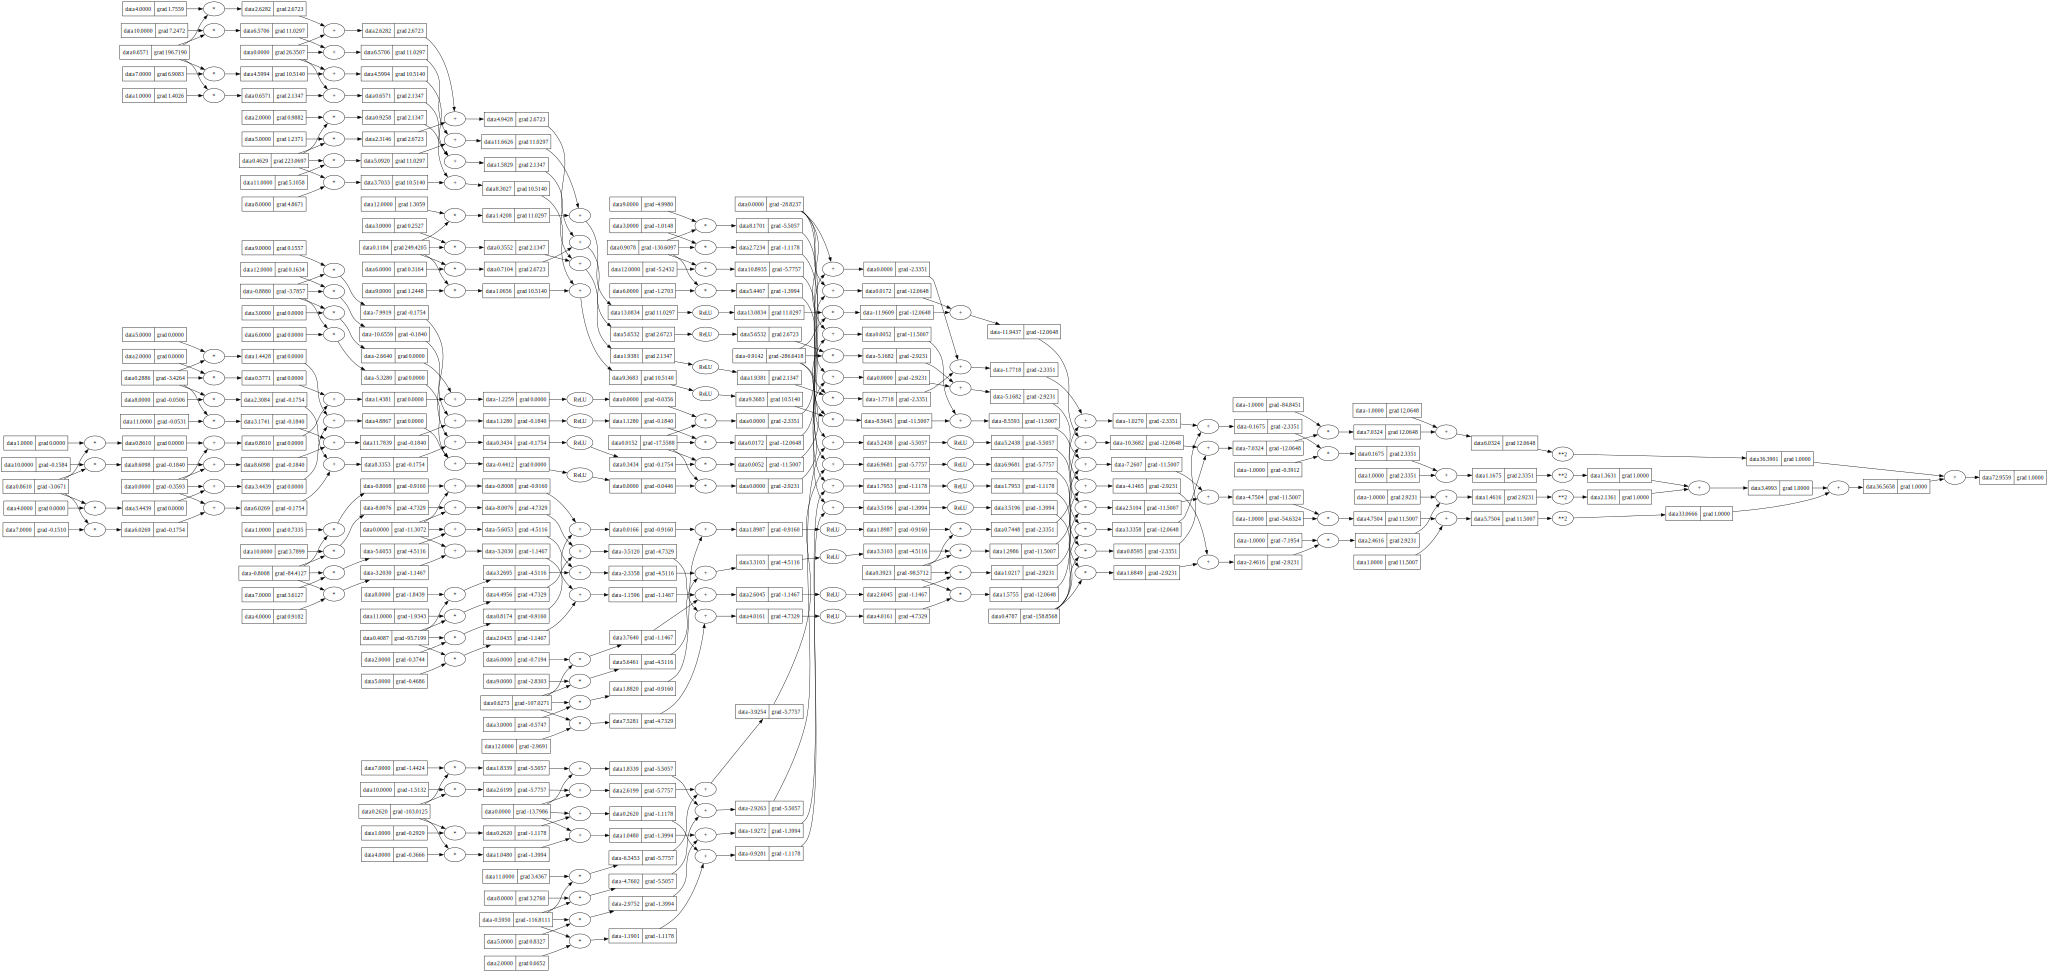

In [6]:
draw_dot(loss)